Width 5 	 Relative Error: 1.665603
Width 10 	 Relative Error: 0.612658
Width 20 	 Relative Error: 0.309176
Width 50 	 Relative Error: 0.136331
Width 100 	 Relative Error: 0.072612
Width 150 	 Relative Error: 0.049427
Width 200 	 Relative Error: 0.037420
Width 250 	 Relative Error: 0.030051
Width 300 	 Relative Error: 0.025189
Width 500 	 Relative Error: 0.015346
Width 700 	 Relative Error: 0.011164
Width 800 	 Relative Error: 0.009724
Width 900 	 Relative Error: 0.008626
Width 1000 	 Relative Error: 0.007762
Width 1500 	 Relative Error: 0.005169
Width 2000 	 Relative Error: 0.003887
Width 3000 	 Relative Error: 0.002608
Width 5000 	 Relative Error: 0.001566
Width 8000 	 Relative Error: 0.000976
Width 10000 	 Relative Error: 0.000782
Width 12000 	 Relative Error: 0.000651
Width 15000 	 Relative Error: 0.000521
Width 17000 	 Relative Error: 0.000459
Width 20000 	 Relative Error: 0.000390
Width 50000 	 Relative Error: 0.000156
Width 100000 	 Relative Error: 0.000078


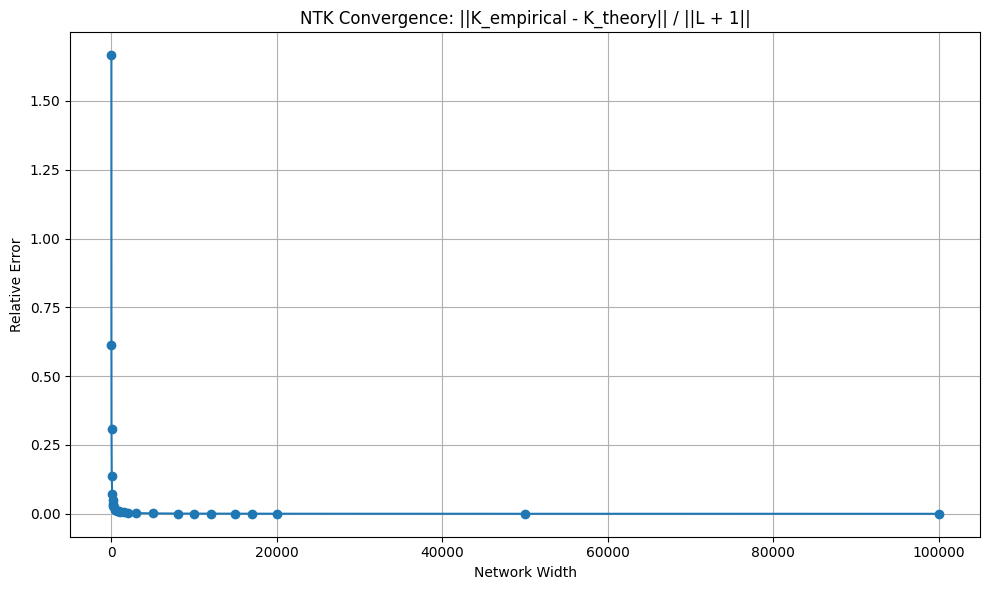

[1.665602684020996,
 0.6126576066017151,
 0.3091764748096466,
 0.13633088767528534,
 0.07261169701814651,
 0.049426931887865067,
 0.037419840693473816,
 0.030051108449697495,
 0.025188883766531944,
 0.015345873311161995,
 0.011163872666656971,
 0.009724335744976997,
 0.008625660091638565,
 0.0077617899514734745,
 0.005169262178242207,
 0.003886861028149724,
 0.002607843140140176,
 0.0015659864293411374,
 0.0009764672722667456,
 0.0007823506603017449,
 0.0006513934931717813,
 0.0005205405759625137,
 0.0004591057950165123,
 0.00039001714321784675,
 0.00015612022252753377,
 7.821089093340561e-05]

In [2]:
import torch
import numpy as np
from typing import Optional, Tuple, List, Union
from torch.func import functional_call, vmap, grad, jacrev
import torch.nn.functional as F

def relu_kernel_covariance(K: torch.Tensor) -> torch.Tensor:
    """
    Compute Σ^(h) for ReLU activation given Λ^(h)
    Args:
        K: 2x2 matrix Λ^(h)(x,x') containing dot products
    """
    # Extract values from K matrix
    k_xx = K[0, 0]  # Σ^(h-1)(x,x)
    k_xy = K[0, 1]  # Σ^(h-1)(x,x')
    k_yy = K[1, 1]  # Σ^(h-1)(x',x')

    
    # Compute normalized correlation (cosine)
    cos_theta = k_xy / torch.sqrt(k_xx * k_yy + 1e-12)
    cos_theta = torch.clamp(cos_theta, -1.0 + 1e-6, 1.0 - 1e-6)
    theta = torch.acos(cos_theta)
    
    # ReLU kernel formula: E[σ(u)σ(v)] for (u,v)~N(0,K)
    # For ReLU: c_σ = 2 (normalization factor)
    return torch.sqrt(k_xx * k_yy) * (torch.sin(theta) + (np.pi - theta) * cos_theta) / np.pi

def relu_kernel_derivative(K: torch.Tensor) -> torch.Tensor:
    """
    Compute Σ̇^(h) for ReLU activation given Λ^(h)
    Args:
        K: 2x2 matrix Λ^(h)(x,x') containing dot products
    """
    # Extract values from K matrix
    k_xx = K[0, 0]  # Σ^(h-1)(x,x)
    k_xy = K[0, 1]  # Σ^(h-1)(x,x')
    k_yy = K[1, 1]  # Σ^(h-1)(x',x')
    
    # Compute normalized correlation
    cos_theta = k_xy / torch.sqrt(k_xx * k_yy + 1e-12)
    cos_theta = torch.clamp(cos_theta, -1.0 + 1e-6, 1.0 - 1e-6)
    theta = torch.acos(cos_theta)
    
    # ReLU derivative kernel: E[σ'(u)σ'(v)] for (u,v)~N(0,K)
    return (np.pi - theta) / np.pi

def theoretical_ntk(X1: torch.Tensor, 
                    X2: Optional[torch.Tensor] = None, 
                    L: int = 2) -> torch.Tensor:
    """
    Compute theoretical NTK for fully-connected neural network with ReLU activation.
    
    Args:
        X1: Input tensor of shape (n1, d)
        X2: Input tensor of shape (n2, d), if None, X2 = X1
        L: Number of hidden layers in the network
    
    Returns:
        Θ: Theoretical NTK matrix of shape (n1, n2)
    """
    if X2 is None:
        X2 = X1

    # Normalize inputs by input dimension (needed for consistent scaling)
    X1 = X1 / np.sqrt(X1.shape[1])
    X2 = X2 / np.sqrt(X2.shape[1])
    
    n1, n2 = X1.shape[0], X2.shape[0]
    Sigma = torch.zeros((L+1, n1, n2), device=X1.device, dtype=X1.dtype)
    Sigma_dot = torch.zeros((L+1, n1, n2), device=X1.device, dtype=X1.dtype)
    Theta = torch.zeros((n1, n2), device=X1.device, dtype=X1.dtype)
    
    # Compute initial kernel: Σ^(0)(x,x') = x^T x'
    Sigma[0] = X1 @ X2.T
    
    # Recursively compute covariance matrices for each layer
    for h in range(1, L+1):
        for i in range(n1):
            for j in range(n2):
                # Build Λ^(h) 2x2 matrix for each (x,x') pair
                Lambda = torch.zeros((2, 2), device=X1.device, dtype=X1.dtype)
                Lambda[0, 0] = Sigma[h-1, i, i]  # Σ^(h-1)(x,x)
                Lambda[0, 1] = Sigma[h-1, i, j]  # Σ^(h-1)(x,x')
                Lambda[1, 0] = Sigma[h-1, i, j]  # Σ^(h-1)(x',x)
                Lambda[1, 1] = Sigma[h-1, j, j]  # Σ^(h-1)(x',x')
                
                # Compute next-layer covariance
                Sigma[h, i, j] = relu_kernel_covariance(Lambda)
                
                # Compute derivative covariance
                Sigma_dot[h, i, j] = relu_kernel_derivative(Lambda)
    
    # Compute the NTK using equation (9)
    for h in range(1, L+1):
        # Extract Σ^(h-1)(x,x')
        sigma_term = Sigma[h-1]
        
        # Compute product of derivative terms
        deriv_product = torch.ones((n1, n2), device=X1.device, dtype=X1.dtype)
        for h_prime in range(h, L+1):
            deriv_product *= Sigma_dot[h_prime]
        
        # Add contribution from this layer
        Theta += sigma_term * deriv_product
    
    return Theta

def compare_ntk_empirical_vs_theoretical(X, width_list=None):
    """
    Compare empirical NTK with theoretical NTK across different widths
    
    Args:
        X: Input data tensor of shape (n, d)
        width_list: List of network widths to test
    
    Returns:
        Plots comparing empirical and theoretical NTK
    """
    if width_list is None:
        width_list = [5, 10, 20, 50, 100, 150, 200, 250, 300, 500, 700, 800, 900, 1000, 1500, 2000, 3000, 5000, 8000, 10000, 12000, 15000, 17000, 20000, 50000, 100000]
    
    # Compute theoretical NTK once (constant regardless of width)
    K_theory = theoretical_ntk(X, L=2)
    
    rel_errors = []
    
    for width in width_list:
        # Set random seed for reproducibility
        torch.manual_seed(42)

        # Initialize parameters for a 2-layer network
        W1 = torch.randn(width, X.shape[1]) / np.sqrt(X.shape[1])
        b1 = torch.zeros(width)
        W2 = torch.randn(1, width) / np.sqrt(width)
        b2 = torch.zeros(1)

        def f(x, W1, W2, b1, b2):
          layer1 = F.relu(x@(W1.T)+b1)
          layer2 = layer1@(W2.T)+b2
          layer2 = layer2.view(-1)
          return layer2


        jacobian = jacrev(f, argnums= (1, 2, 3, 4))(X, W1, W2, b1, b2)
        K_emp = torch.stack([j.flatten(1)@k.flatten(1).T for j,k in zip(jacobian, jacobian)]).sum(0)
        
        
        # Scale empirical NTK appropriately
        K_emp = K_emp / width
        
        # Compute relative error
        rel_error = torch.norm(K_emp - K_theory) / torch.tensor(width + 1)
        rel_errors.append(rel_error.item())
        
        print(f"Width {width} \t Relative Error: {rel_error:.6f}")
    
    # Plot results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(width_list, rel_errors, 'o-')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Network Width')
    plt.ylabel('Relative Error')
    plt.title('NTK Convergence: ||K_empirical - K_theory|| / ||L + 1||')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return rel_errors

# Example usage:
X = torch.randn(20, 20)  # 10 samples, 20 features
compare_ntk_empirical_vs_theoretical(X)
